## While we start, please run the cell below. It will set up the environment for you

In [ ]:
# Download data for he project
!wget -r -O diabetes_data.csv https://raw.githubusercontent.com/mandar-karhade/Medcon2024/main/Data%20files/diabetes_data.csv

# Install all the libraries as a one single statement
!pip -qqq install pandas numpy seaborn==0.12.2 matplotlib ydata-profiling[notebook]==4.1.2 missingno==0.5.2 pycaret[analysis]==3.0.4 PyYAML==6.0 joblib==1.3.0 mlflow==2.10.2 shap==0.44.0 interpret-community==0.31.0 Werkzeug==2.2.2


**Please restart session using Runtime >> Restart session (CTRL + M)** :



---

# Goals
### At the end of this hour, we would have achieved following goals -  

1.   Get hands dirty with Google Colab Notebooks
2.   Have a better understanding of the broader AI/ML activities
3.   Got to see the data cleaning process
4.   Completed a run of a realistic AI/ML experiment
5.   Completed a run of a realistic AI/ML experiment with AutoML
6.   Have a better understanding of what artifacts to save/submit to FDA




# 3000 ft View of Machine learning in production

Machine learning / AI in production is a complex orchestra and iterative process. The orchestration of "other" activities happens around each Machine learning experiment which is at the core. Today will look at the experiment itself and try to simplify it. The objective for this presentation is for all of us to be able to actually complete an experiment and feel comfortable with the basics of a Machine learning project.

For this experiment, the business understanding, problem statement, KPI for success, and appropriation of time and money has been completed. Therefore, we start with the data.

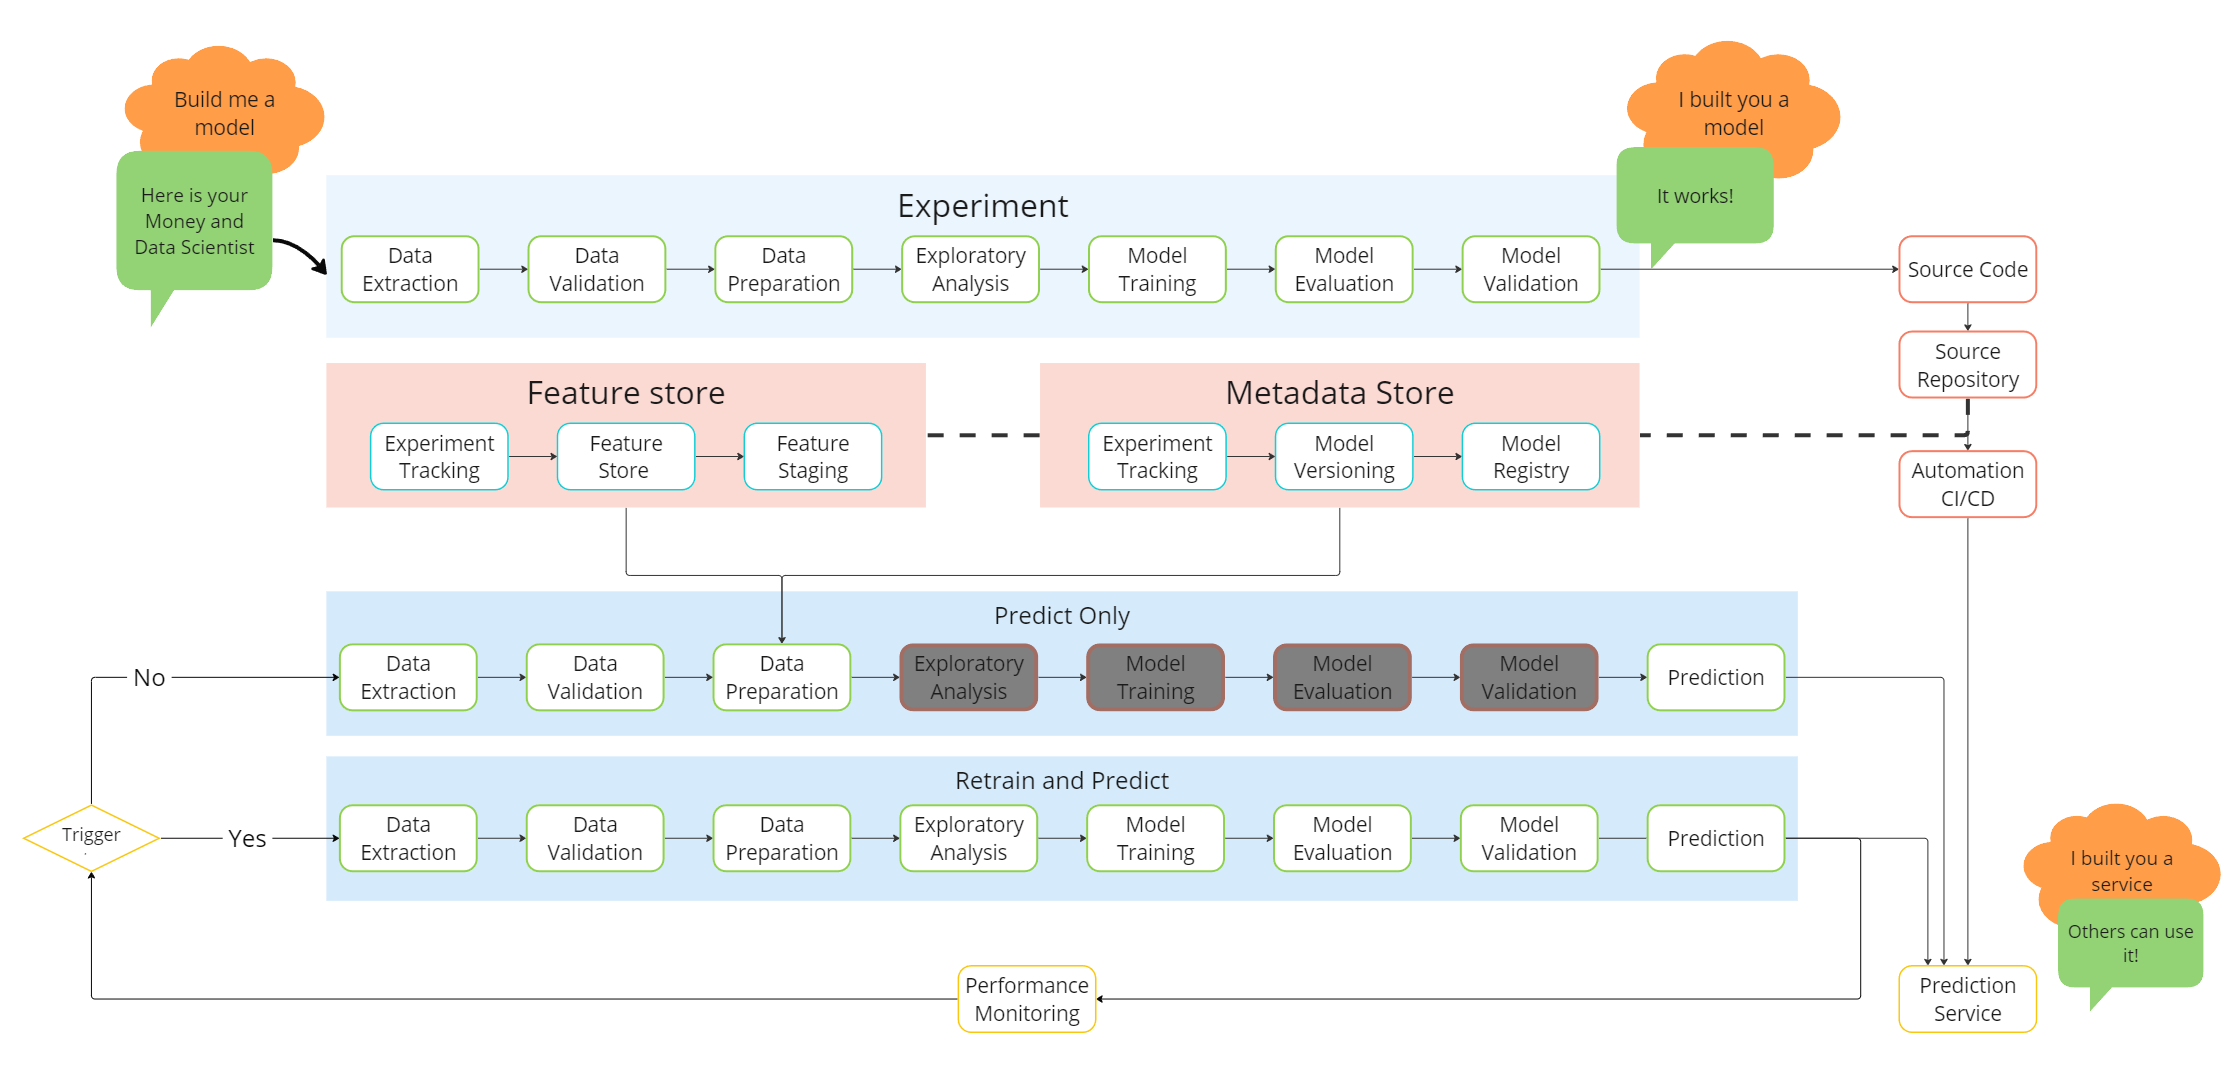

## Today we focus on Model Building
Assuming that the data has been collected and validated. Now we need to -

1. prepare data
2. understand the data using Exploratory data analysis
3. train a model or multiple models
4. evaluate our model choice
5. validate the model against data that was not used during the training/testing to simulate real-life performance.

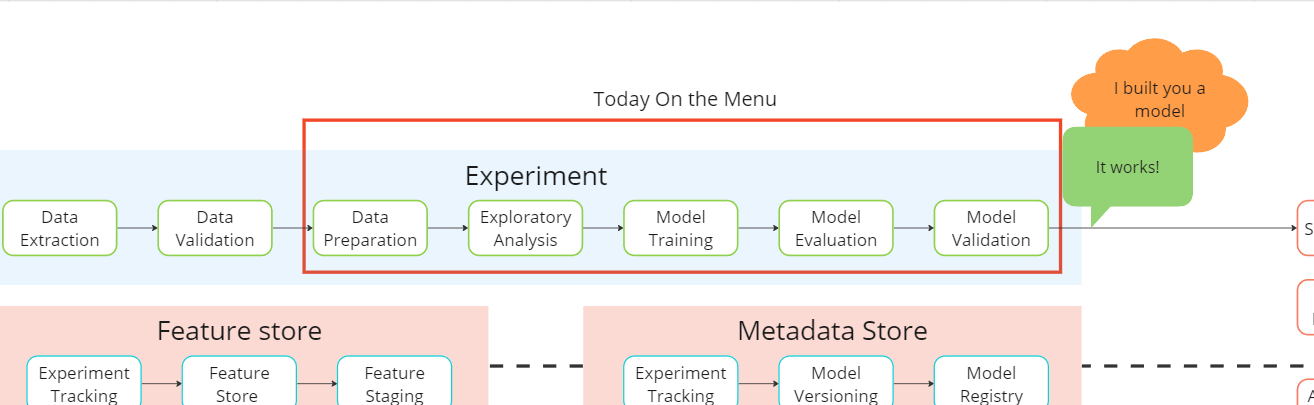








## Importing libraries for running this experiment.
The libraries are grouped by their purpose.


1.   Reading the data
2.   Understanding and profiling the data
3.   Machine learning - model development
4.   Machine learning - performance measurement
5.   Other libraries to make our life easy

In [ ]:
# import packages

# Reading the data in -
import numpy as np
import pandas as pd

# Profiling the data through Exploeratory data analsis
import seaborn as sns
from matplotlib import pyplot as plt
from ydata_profiling import ProfileReport
import missingno as msno
from sklearn.impute import SimpleImputer

# Machine learning - model development
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Machine larning - performance measurement
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import scipy.stats

# Otehr libraries
import warnings
warnings.filterwarnings('ignore')
from google.colab import data_table
data_table.enable_dataframe_formatter()


# Understanding our data - Profiling it - Fixing it

In [ ]:
# Reading the data
data = pd.read_csv('diabetes_data.csv')

# Understanding how the data looks
display(data.head(n=10))
display('-'*100)

# How large is the data?
display(f'The data has {data.shape[1]} columns, and {data.shape[0]} rows')
display('-'*100)

# What are the columns in the data
display(f'Column names: {", ".join(list(data.columns))}')
display('-'*100)

# what is the format of data
display(pd.DataFrame({"column-name": data.columns,
              "non-nulls": len(data)-data.isnull().sum().values,
              "nulls": data.isnull().sum().values,
              "type": data.dtypes.values}))

In [ ]:
profile = ProfileReport(data,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile before cleaning.html')

## Folks we have a missingness problem

Blood Pressure, Skin thickness, Insuling levels, BMI, Glucose levels, and Age of ZERO are incompatible with life! That means we have a problem.

We have to fix it -

### We have a few options
*   We can check which patients did we have the least data on -
*   We can check if the missingness is real and then decide if we want to -
  - remove those observations
  - remove those features (variables)
  - replace/impute those variables



## Fixing ZERO and Missing values

### First, we will replace all zeros to missing values
* we have some good packages to investigate missingness (and I am lazy ;) )


In [ ]:
# data.update(data[['Pregnancies','BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']].replace(0, np.nan, inplace=True))
data_cleaned = data.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  data_cleaned[i].replace(0, np.nan, inplace=True)


In [ ]:
# Lets find percent missingness in the data for each variable
missingness_sorted = sorted(pd.DataFrame(data_cleaned.isna().sum()).to_dict()[0].items(), key=lambda x: -x[1])
list(map(lambda x: (x[0], round(x[1]/data_cleaned.shape[0]*100, 2)), missingness_sorted))

In [ ]:
# Further investigate missing numbers to check which missing variables always go together
print("missingness correlation between variables")
msno.heatmap(data_cleaned, figsize=(6,4), fontsize=10)
print("-"*100 + "\n")

## Decision time! We are keeping Insulin
* Insulin missing for 48.7% observations was heartbreaking
* Skin thickness was also missing for approximately 30% observations
* Clinically I hate to see Insulin missing for a diabetes dataset but thats life!

In [ ]:
# imputing all missing values with mean fore all columns
simple_imputed_data = data_cleaned.copy()
for i in ['BloodPressure','SkinThickness','Insulin','BMI','Glucose','Age']:
  # Start the imputer engine and tell it that missing values are noted by NaN values and it has to use the 'mean' of all other values to fill in as a strategy.
  imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

  # Input the real data for each column to the imputer engine so that it can calculate what needs to be imputed.
  imputer =  imputer.fit(simple_imputed_data[[i]].values)

  # Replace the old columne with the new column of imputed NaN with mean.
  simple_imputed_data[i] = imputer.transform(simple_imputed_data[[i]].values)


# Lets rerun profile report again
profile = ProfileReport(simple_imputed_data,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after simple imputation.html')


In [ ]:

# Lets see the difference between original data and the new data

print('Original data with Zeros')
display(data.head())
print('Original data with suspected zeros replaced with NaN')
display(data.head())
print('Imputed data with NaN replaced with mean')
display(simple_imputed_data.head())

That was a ridiculous distribution!

We need a better way to fix missingness.
Lets try another imputer. This time we will use other columns to inform value at the missing observation.

However, we need to first remove the outcome from the data so that we dont impute using the outcome!

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Lets create a new copy of the cleaned data (the one with the NaNs)
multi_imputed_data = data_cleaned.copy()

# Lets remove the influence of the outcome from the imputations - otherwise we are fitting the imputed values based on the outcome. This is information leakage
multi_imputed_data_outcome = multi_imputed_data[['Outcome']]
multi_imputed_data.drop(columns = ['Outcome'], inplace=True)

# Lets impute
imputer = IterativeImputer(missing_values=np.nan, max_iter=10, random_state=0)
imputer.fit(multi_imputed_data.values)
multi_imputed_data = pd.DataFrame(imputer.transform(multi_imputed_data), columns=multi_imputed_data.columns)

# Putting togetherFinal dataframe by adding back the outcomes
Finaldata = pd.concat([multi_imputed_data, multi_imputed_data_outcome], axis = 1)
Finaldata.head()

# Lets rerun profile report
profile = ProfileReport(Finaldata,
                        title="Profiling Report",
                        dark_mode = True,
                        correlations=None,
                        interactions = None,
                        missing_diagrams={
                            "heatmap": False,
                            "bar" : False,
                            "matrix" : False
                            }
                        )
profile.to_notebook_iframe()
profile.to_file('data profile after multiple imputation.html.html')



---

**Lets move to the next step**

---


# Data Cleaning is completed! Let's model

### There are so many algorithms to select from (Cheatsheet)
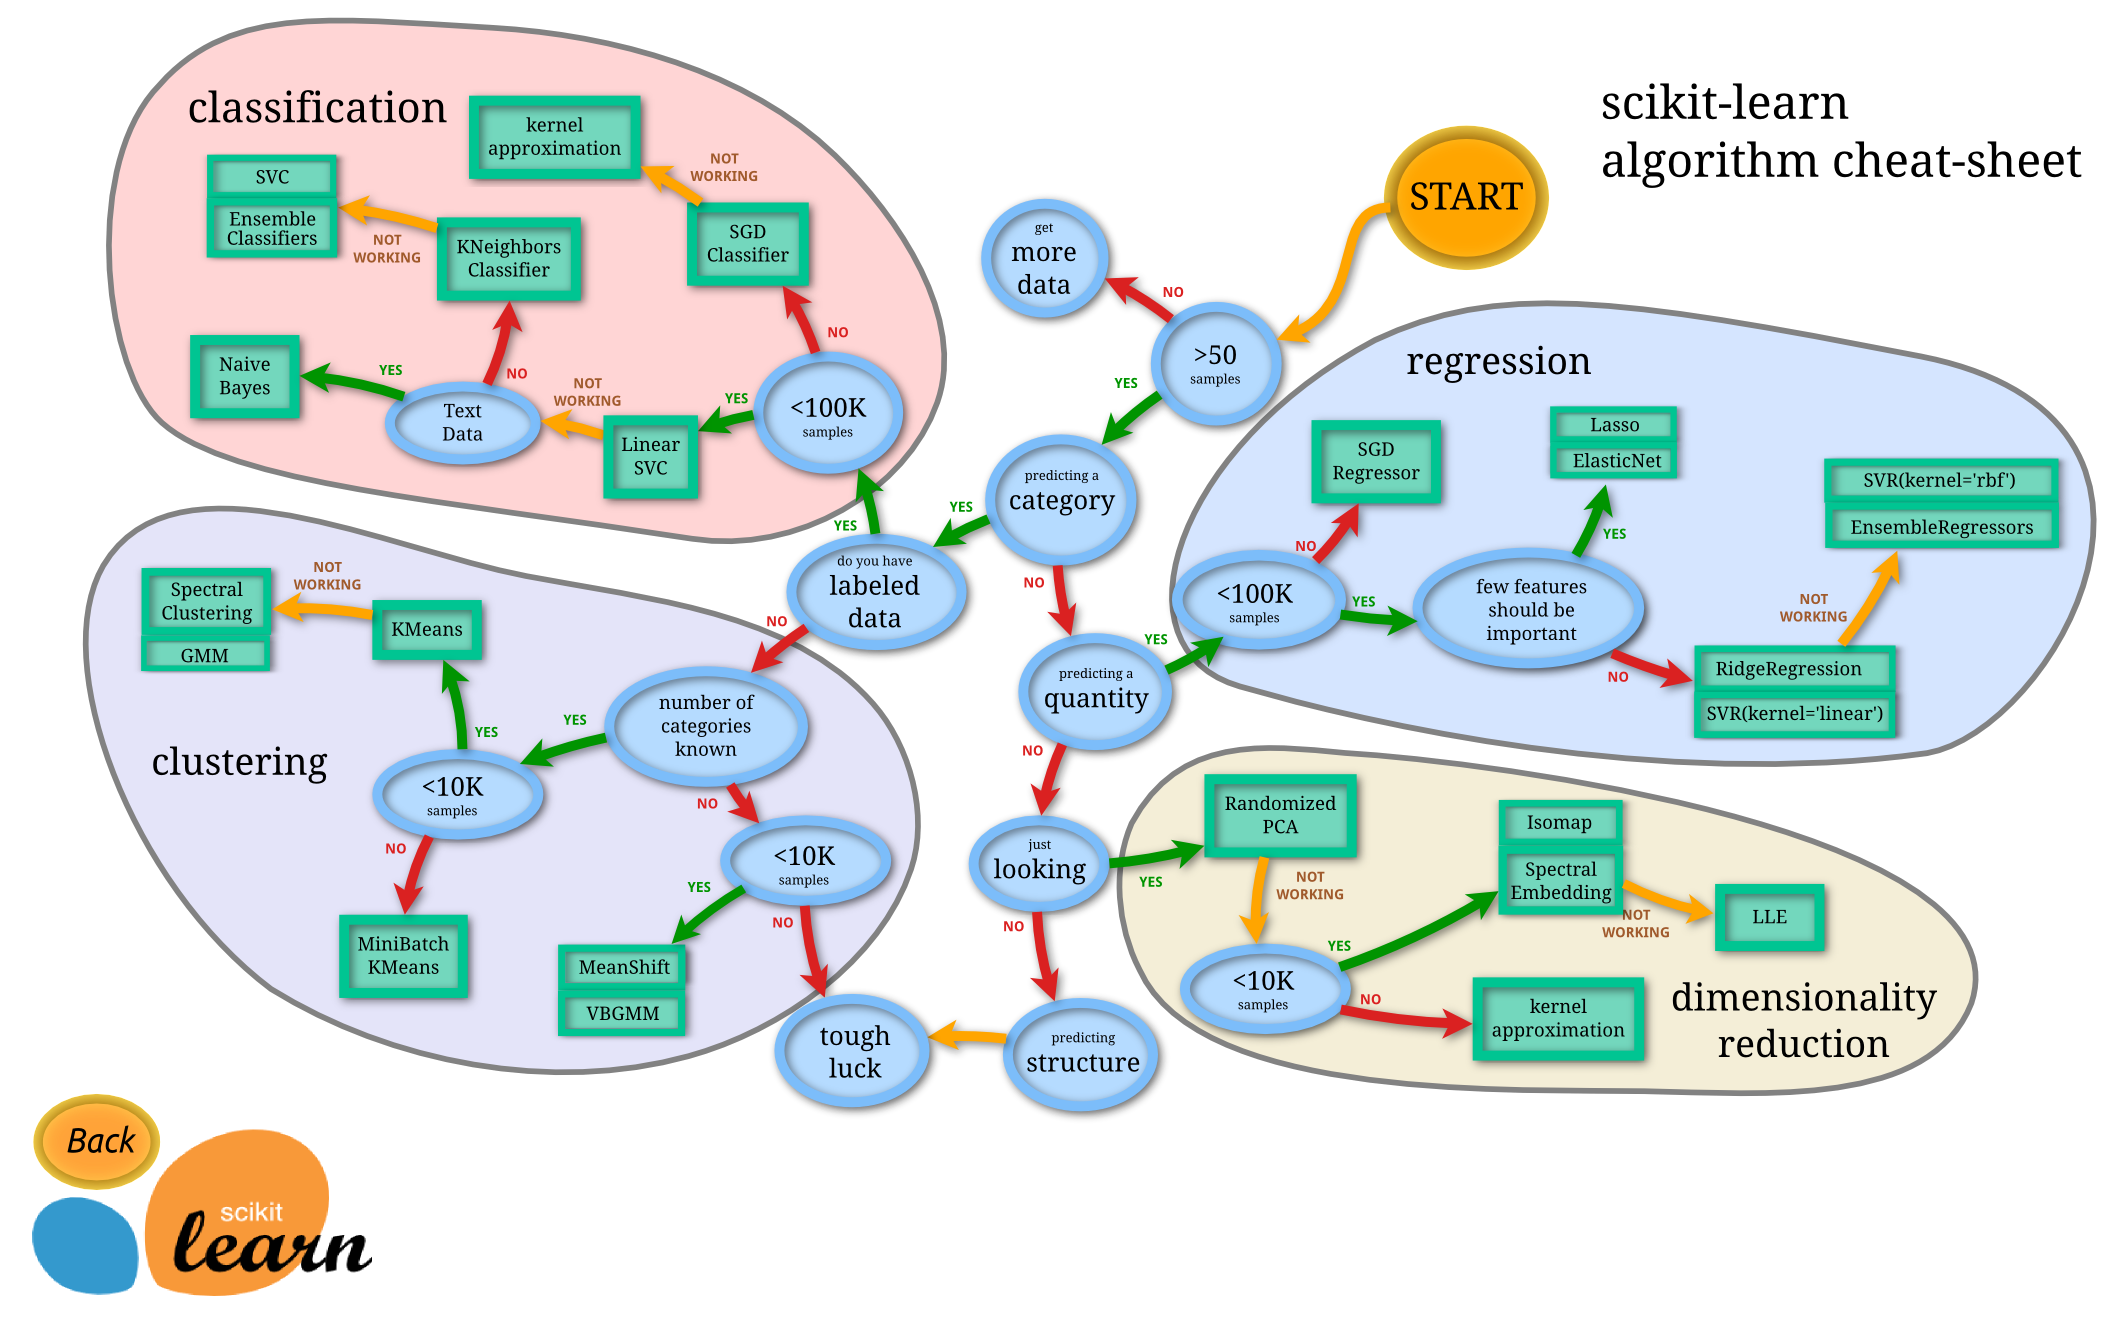

## Lets try one of the many choices

We will use `KNeighborsClassifier` for our first Wrong model choice!

KNeighborsClassifier is an algorithm that effectively categorizes data points according to the trends found in that said point's nearest data points or neighbors.

Frist we need to standardize and scale the data. StandardScaler removes the mean and scales each feature/variable to unit variance. Having unit (1) variance makes all variables to have the same influence over the outcome.

Then we split the data into training and testing data.
Training data will be used to train the model while testing data will be used to test the accuracy model.

In [ ]:
from sklearn.preprocessing import StandardScaler
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# Standardize the data set
scaler = StandardScaler()
scaler.fit(Finaldata.drop('Outcome', axis=1))
scaled_features = scaler.transform(Finaldata.drop('Outcome', axis=1))
scaled_data = pd.DataFrame(scaled_features, columns = Finaldata.drop('Outcome', axis=1).columns)



# Split the data set into training data and test data
x = scaled_data
y = Finaldata['Outcome']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.1, random_state=9999)




# Train the model and make predictions
model = KNeighborsClassifier(n_neighbors = 5, weights='distance')
model.fit(x_training_data, y_training_data)
predictions = model.predict(x_test_data)




# Performance measurement in training data
print(f"Confusion matrix in training data: \n{classification_report(y_training_data, model.predict(x_training_data))}")
print('-'*100)
print('How well did we do on the training data?')
fig, ax = plt.subplots(figsize=(3,3))
cmp = ConfusionMatrixDisplay.from_estimator(model, x_training_data, y_training_data, ax=ax)
plt.show()
print('-'*100)




# Performance measurement in test data
print(f"Confusion matrix in testing data: \n{classification_report(y_test_data, predictions)}")
print('-'*100)
print('How many wrong predictions are we creating?')
fig, ax = plt.subplots(figsize=(3,3))
cmp = ConfusionMatrixDisplay.from_estimator(model, x_test_data, y_test_data, ax=ax)
plt.show()

print('-'*100)




In [ ]:
#Selecting an optimal K value
print('What is the right number of neighbors?')
error_rates = []
accuracy_scores = []
f1_scores = []
for i in np.arange(1, 100):
    new_model = KNeighborsClassifier(n_neighbors = i)
    new_model.fit(x_training_data, y_training_data)
    new_predictions = new_model.predict(x_test_data)
    error_rates.append(np.mean(new_predictions != y_test_data))
    accuracy_scores.append(accuracy_score(y_test_data, new_predictions))
    f1_scores.append(f1_score(y_test_data, new_predictions))

plt.figure()
plt.plot(f1_scores, label="f1_scores")
plt.plot(accuracy_scores, label="accuracy_scores")
plt.show()


We just completed a model creation pass (an experiment) and predicted the outcomes. And even quickly dipped our toes in the hyperparameter tuning.!!


## Which classificatiom model is the best one though!

Lets run a loop over all models that we could find and run an experiment.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Linear SVM",
    "QDA",
    "Naive Bayes",
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),

    KNeighborsClassifier(3),
    SVC(gamma='auto', C=1, degree = 1, random_state=22),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

figure = plt.figure(figsize=(40, 4))
i = 1

# preprocess dataset, split into training and test part
x= Finaldata[['Glucose', 'BMI']]

# Create a data of the outcomes
y= Finaldata['Outcome']

X, y = x.to_numpy(), y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")

# Plot the training points
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())
i += 1

# iterate over classifiers
for name, clf in zip(names, classifiers):

    ax = plt.subplot(1, len(classifiers) + 1, i)
    ax.set_title(names[i-2])

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i += 1

plt.tight_layout()
plt.show()

## Comparing the Accuracy metrics

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Linear SVM",
    "QDA",
    "Naive Bayes",
    "Nearest Neighbors",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
]

classifiers = [
    SVC(kernel="linear", C=0.025, random_state=42 , probability=True),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),

    KNeighborsClassifier(3),
    SVC(gamma='auto', C=1, degree = 1, random_state=22, probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
]

# preprocess dataset, split into training and test part
x = Finaldata[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]

# Create a data of the outcomes
y = Finaldata['Outcome']

X, y = x.to_numpy(), y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


for name, clf in zip(names, classifiers):

  clf = make_pipeline(StandardScaler(), clf)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)

  y_pred_proba = clf.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label=f"{name}, auc="+str(round(auc,3)))
  plt.legend(loc=4)

plt.show()




---
---






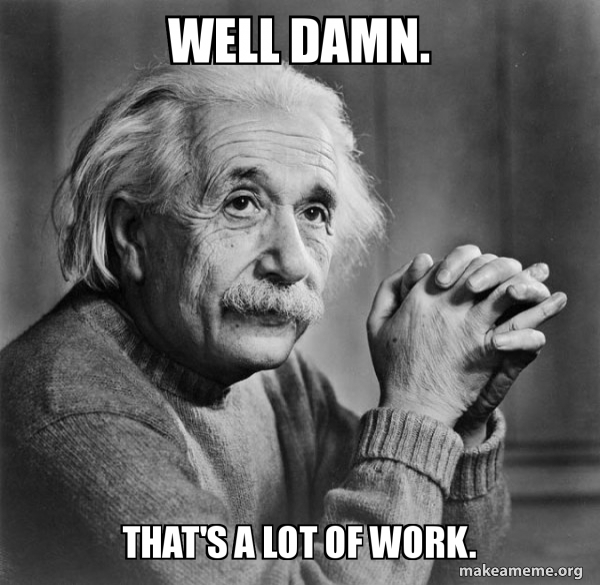

# AutoML

## only Carets, No sticks
#### Lets make our life easier by using completely OpenSource projects like PyCaret

In [ ]:
# Import library
from pycaret.classification import *

# Set up data and project
clf = setup(Finaldata, target = 'Outcome', session_id=123, log_experiment=True, experiment_name='juice1')

## Selecting and evaluating the best model

In [ ]:
# Let the data choose the best model
best_model = clf.compare_models()

In [ ]:
# Let the caret show us the evaluation results for the best model
clf.evaluate_model(best_model)

In [ ]:
# Interpret the best model
fig = interpret_model(best_model, 'msa')
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    height = 400, width = 800,
    paper_bgcolor="White",
    font_size=12,
    title_font_size=12
)

fig.show()

In [ ]:
# Check fairness of the model based on Pregnancies (Is the model less accurate for Pregnant people?)
fairness = check_fairness(best_model, sensitive_features = ['Pregnancies'])

## But I want to try out one of the Non-best models


In [ ]:
# But I want to try out one of the Non-best models

# Get the model
model = create_model('lightgbm')

# Evaluate it
evaluate_model(model)

# Check fairness
fairness = check_fairness(model, sensitive_features = ['Pregnancies'])